**Group: g16**

- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [79]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

### Load Data

In [69]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [70]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [71]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


#### Plot some samples

In [72]:
X_train_per_class = {}
for c in range(N_CLASSES):
    # select sample of given class c
    mask = np.random.choice(np.where(Y_train == c)[0], 1)
    X_train_per_class[c] = X_train[mask]

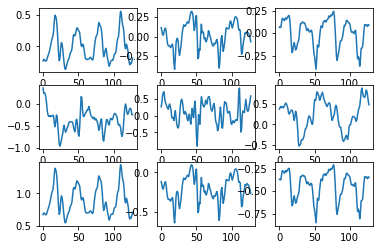

In [73]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [74]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

In [75]:
# Z normalization
X_train_norm = X_train
for i, _ in enumerate(means):
    X_train[:,:,i] = (X_train[:,:,i] - means[i]) / stdevs[i]
    
X_test_norm = X_test
for i, _ in enumerate(means):
    X_test[:,:,i] = (X_test[:,:,i] - means[i]) / stdevs[i]

In [80]:
means = np.mean(X_train_norm, axis=(0,1))
stdevs = np.std(X_train_norm, axis=(0,1))

print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(math.sqrt(means[i]**2), stdevs[i]))

Mean / Stdev for each feature:
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000
 0.0000 |  1.0000


In [88]:
Y_train_categorical = one_hot(Y_train, N_CLASSES)
Y_test_categorical = one_hot(Y_test, N_CLASSES)

print(Y_train_categorical[0])

[0. 0. 0. 0. 1. 0.]


### Tensorflow

In [227]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import SimpleRNN, LSTM

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

TensorFlow version: 2.0.0-alpha0


## Helpers

In [113]:
# plotting function
def plot_loss_acc(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Testing loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Testing acc')
    ax2.legend()
    ax2.grid()

In [176]:
# automate the evaluation
def evaluate(model, batch_size, epochs):
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    
    log = model.fit(
        X_train_norm, 
        Y_train_categorical, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1,
        validation_data=(X_test_norm, Y_test_categorical)
    )
    
    plot_loss_acc(log)

In [188]:
# automate cm
def cm(model):
    y_test = Y_test.flatten()
    y_hat = model.predict(X_test)
    y_pred = np.argmax(y_hat, axis=1)
    
    plot_heatmap(y_test, y_pred)

In [261]:
# heatmap function
def plot_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,7))
    sn.heatmap(cmn, annot=True, xticklabels=LABELS, yticklabels=LABELS)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with a single layer of LSTM
* Model with several layers of LSTMs
* Model with several CNN layers
* MLP

Try with different number of units. Add regularisation if needed (e.g. when working with MLPs).

Report about your findings.

### Single Layer SimpleRNN

In [197]:
### START YOUR CODE

simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(6, input_shape=(128, 9)))
simple_rnn.add(Dense(6, activation='softmax'))

simple_rnn.summary()

### END YOUR CODE

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 6)                 96        
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 42        
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 1s 157us/sample - loss: 1.7142 - accuracy: 0.2455 - val_loss: 1.6935 - val_accuracy: 0.2345
Epoch 2/10
7352/7352 [==============================] - 1s 100us/sample - loss: 1.6275 - accuracy: 0.2641 - val_loss: 1.6346 - val_accuracy: 0.2603
Epoch 3/10
7352/7352 [==============================] - 1s 96us/sample - loss: 1.5659 - accuracy: 0.2956 - val_loss: 1.5890 - val_accuracy: 0.2881
Epoch 4/10
7352/7352 [==============================] - 1s 109us/sample - loss: 1.5117 - accuracy: 0.3653 - val_loss: 1.5468 - val_accuracy: 0.3895
Epoch 5/10
7352/7352 [==============================] - 1s 111us/sample - loss: 1.4649 - accuracy: 0.4721 - val_loss: 1.5111 - val_accuracy: 0.4418
Epoch 6/10
7352/7352 [==============================] - 1s 104us/sample - loss: 1.4224 - accuracy: 0.5128 - val_loss: 1.4786 - val_accuracy: 0.4679
Epoch 7/10
7352/7352 [==============================] - 1s 95us/s

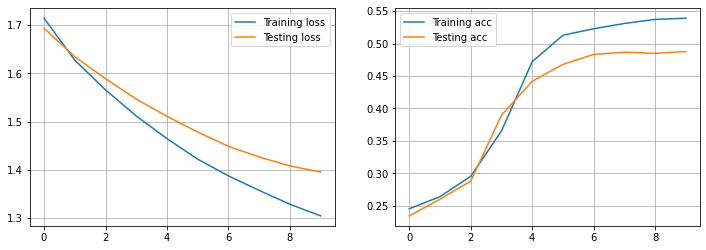

In [195]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_rnn_simple = evaluate(simple_rnn, batch_size, epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 1s 151us/sample - loss: 1.8140 - accuracy: 0.2901 - val_loss: 1.7790 - val_accuracy: 0.3414
Epoch 2/40
7352/7352 [==============================] - 1s 102us/sample - loss: 1.7314 - accuracy: 0.4071 - val_loss: 1.6978 - val_accuracy: 0.4472
Epoch 3/40
7352/7352 [==============================] - 1s 98us/sample - loss: 1.6385 - accuracy: 0.4682 - val_loss: 1.6076 - val_accuracy: 0.4533
Epoch 4/40
7352/7352 [==============================] - 1s 100us/sample - loss: 1.5477 - accuracy: 0.4619 - val_loss: 1.5286 - val_accuracy: 0.4354
Epoch 5/40
7352/7352 [==============================] - 1s 102us/sample - loss: 1.4728 - accuracy: 0.4591 - val_loss: 1.4633 - val_accuracy: 0.4408
Epoch 6/40
7352/7352 [==============================] - 1s 103us/sample - loss: 1.4104 - accuracy: 0.4659 - val_loss: 1.4075 - val_accuracy: 0.4537
Epoch 7/40
7352/7352 [==============================] - 1s 101us/

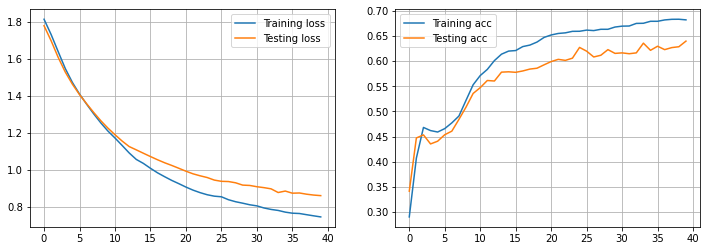

In [198]:
### START YOUR CODE
batch_size = 256
epochs = 40

log_rnn_simple = evaluate(simple_rnn, batch_size, epochs)

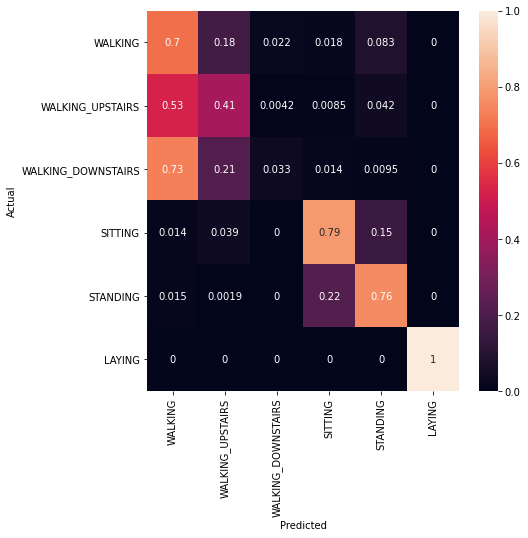

In [262]:
cm(simple_rnn)

#### Findings

We only achieved a test accuracy of `0.64` with `SimpleRNN`. This is mainly do to the model having difficulties differentiating between `WALKING`, `WALKING_UPSTAIRS` and `WALKING_DOWNSTAIRS`. Thus, there are a lot of false-positives, especially for `WALKING_UPSTAIRS`, where only `41` percent where true-positives. `LAYING` in contrast was accurately predicted in all cases.

A higher number of units, as well as a bigger number of epochs seem to improve the predictions.

### LSTM

In [200]:
### START YOUR CODE

simple_lstm = Sequential()
simple_lstm.add(LSTM(128, input_shape=(128, 9)))
simple_lstm.add(Dense(6, activation='softmax'))

simple_lstm.summary()

### END YOUR CODE

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_4 (UnifiedLSTM) (None, 128)               70656     
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 11s 2ms/sample - loss: 1.2499 - accuracy: 0.5424 - val_loss: 0.8823 - val_accuracy: 0.6844
Epoch 2/10
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.5143 - accuracy: 0.8377 - val_loss: 0.6002 - val_accuracy: 0.8127
Epoch 3/10
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.2757 - accuracy: 0.9207 - val_loss: 0.4073 - val_accuracy: 0.8761
Epoch 4/10
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.2363 - accuracy: 0.9177 - val_loss: 0.3968 - val_accuracy: 0.8571
Epoch 5/10
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.1891 - accuracy: 0.9338 - val_loss: 0.3062 - val_accuracy: 0.8989
Epoch 6/10
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.2283 - accuracy: 0.9115 - val_loss: 0.3391 - val_accuracy: 0.8938
Epoch 7/10
7352/7352 [==============================] - 11s 1ms/sample

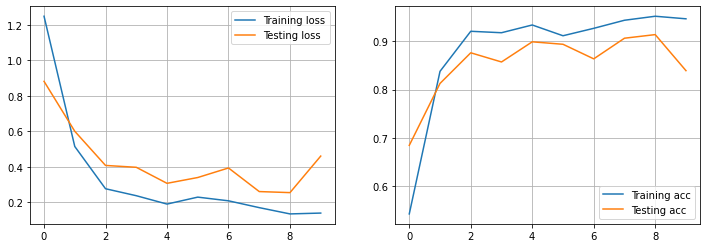

In [201]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_simple_lstm = evaluate(simple_lstm, batch_size, epochs)

In [204]:
### START YOUR CODE

lstm_simple_big = Sequential()
lstm_simple_big.add(LSTM(256, input_shape=(128, 9)))
lstm_simple_big.add(Dense(6, activation='softmax'))

lstm_simple_big.summary()

### END YOUR CODE

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_6 (UnifiedLSTM) (None, 256)               272384    
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 1542      
Total params: 273,926
Trainable params: 273,926
Non-trainable params: 0
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 21s 3ms/sample - loss: 0.9866 - accuracy: 0.6251 - val_loss: 0.7140 - val_accuracy: 0.7604
Epoch 2/10
7352/7352 [==============================] - 21s 3ms/sample - loss: 0.3704 - accuracy: 0.8762 - val_loss: 0.5222 - val_accuracy: 0.8534
Epoch 3/10
7352/7352 [==============================] - 23s 3ms/sample - loss: 0.2104 - accuracy: 0.9291 - val_loss: 0.3039 - val_accuracy: 0.8918
Epoch 4/10
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.1865 - accuracy: 0.9290 - val_loss: 0.3061 - val_accuracy: 0.8965
Epoch 5/10
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.1829 - accuracy: 0.9317 - val_loss: 0.3058 - val_accuracy: 0.9023
Epoch 6/10
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.1309 - accuracy: 0.9468 - val_loss: 0.2654 - val_accuracy: 0.9077
Epoch 7/10
7352/7352 [==============================] - 19s 3ms/sample

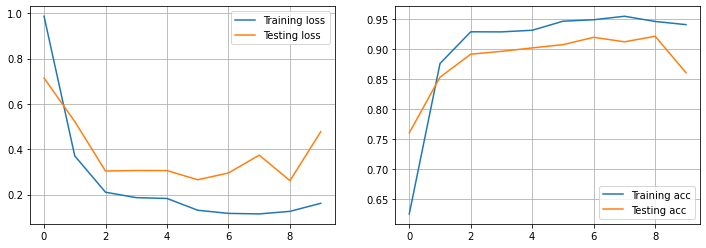

In [205]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_simple_lstm_big = evaluate(lstm_simple_big, batch_size, epochs)

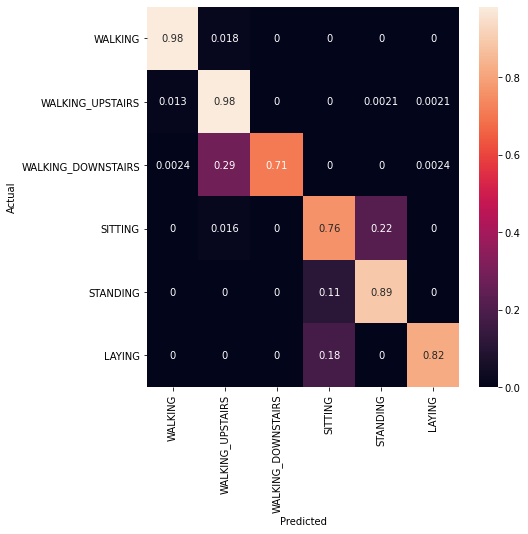

In [206]:
cm(lstm_simple_big)

#### Findings

A simple one-layer `LSTM` already achieves great results, with test accuracies of up to `0.92`. However, `10` epochs seem to be a bit too much. From the confusion matrix, we can see that the `WALKING` and `WALKING_UPSTAIRS` are recognized correctly in `98` percent of the time. However, the model has some difficulties differentiating between `WALKING_UPSTAIRS` and `WALKING_DOWNSTAIRS`. Interestingly, `LAYING` is quite often confused for `SITTING` - something that the `SimpleRNN` did perfectly. 

### Stacked LSTMs

In [218]:
### START YOUR CODE

stacked_lstm = Sequential()
stacked_lstm.add(LSTM(256, input_shape=(128, 9), return_sequences=True))
stacked_lstm.add(LSTM(128, return_sequences=True))
stacked_lstm.add(LSTM(64))
stacked_lstm.add(Dense(6, activation='softmax'))

stacked_lstm.summary()

### END YOUR CODE

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_22 (UnifiedLSTM (None, 128, 256)          272384    
_________________________________________________________________
unified_lstm_23 (UnifiedLSTM (None, 128, 128)          197120    
_________________________________________________________________
unified_lstm_24 (UnifiedLSTM (None, 64)                49408     
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 390       
Total params: 519,302
Trainable params: 519,302
Non-trainable params: 0
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 43s 6ms/sample - loss: 0.8848 - accuracy: 0.6726 - val_loss: 0.5375 - val_accuracy: 0.8202
Epoch 2/10
7352/7352 [==============================] - 40s 5ms/sample - loss: 0.2192 - accuracy: 0.9246 - val_loss: 0.3241 - val_accuracy: 0.8948
Epoch 3/10
7352/7352 [==============================] - 40s 5ms/sample - loss: 0.1660 - accuracy: 0.9431 - val_loss: 0.2661 - val_accuracy: 0.9067
Epoch 4/10
7352/7352 [==============================] - 43s 6ms/sample - loss: 0.1298 - accuracy: 0.9544 - val_loss: 0.2759 - val_accuracy: 0.9053
Epoch 5/10
7352/7352 [==============================] - 40s 5ms/sample - loss: 0.1156 - accuracy: 0.9566 - val_loss: 0.3000 - val_accuracy: 0.9148
Epoch 6/10
7352/7352 [==============================] - 39s 5ms/sample - loss: 0.1117 - accuracy: 0.9565 - val_loss: 0.3466 - val_accuracy: 0.9060
Epoch 7/10
7352/7352 [==============================] - 40s 5ms/sample

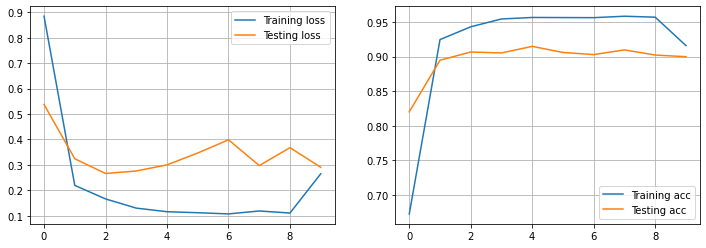

In [211]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_stacked_lstm = evaluate(stacked_lstm, batch_size, epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/6
7352/7352 [==============================] - 62s 8ms/sample - loss: 0.5225 - accuracy: 0.8029 - val_loss: 0.3052 - val_accuracy: 0.9070
Epoch 2/6
7352/7352 [==============================] - 65s 9ms/sample - loss: 0.1731 - accuracy: 0.9340 - val_loss: 0.2303 - val_accuracy: 0.9121
Epoch 3/6
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.1443 - accuracy: 0.9421 - val_loss: 0.3391 - val_accuracy: 0.8904
Epoch 4/6
7352/7352 [==============================] - 70s 10ms/sample - loss: 0.1277 - accuracy: 0.9547 - val_loss: 0.3214 - val_accuracy: 0.9050
Epoch 5/6
7352/7352 [==============================] - 69s 9ms/sample - loss: 0.1343 - accuracy: 0.9495 - val_loss: 0.2602 - val_accuracy: 0.9220
Epoch 6/6
7352/7352 [==============================] - 70s 9ms/sample - loss: 0.1190 - accuracy: 0.9494 - val_loss: 0.1940 - val_accuracy: 0.9301


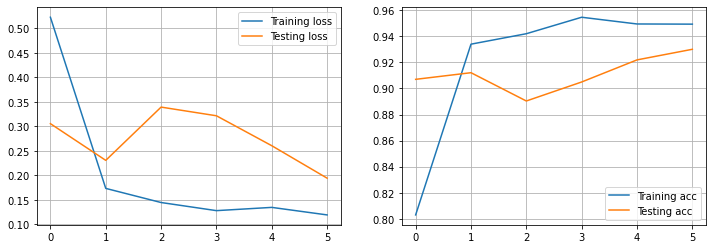

In [219]:
### START YOUR CODE
batch_size = 64
epochs = 6

log_stacked_lstm = evaluate(stacked_lstm, batch_size, epochs)

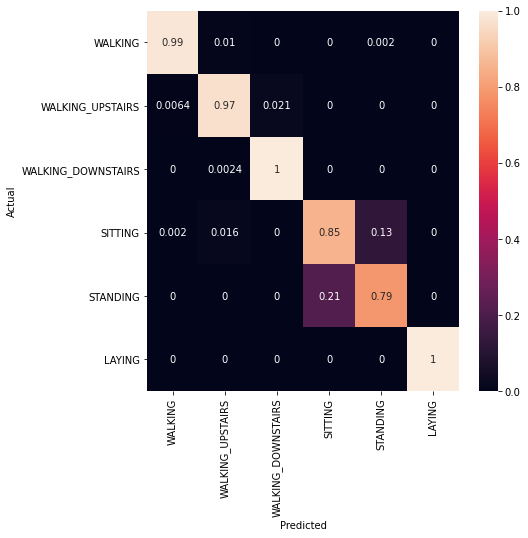

In [220]:
cm(stacked_lstm)

#### Findings

The stacked `LSTM` model performs even better than the simple one. The test accuracy of `0.93` is a bit higher. All `WALKING` categories get predicted almost perfectly. Only `SITTING` and `STANDING` get confused sometimes. `LYING` gets predicted perfectly again - in contrast to the simple `LSTM` model.

### CNN (Conv1d)

In [231]:
### START YOUR CODE

cnn = Sequential()
cnn.add(Conv1D(32, 3, activation='tanh', padding='same', input_shape=(128, 9)))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(16, 3, activation='tanh', padding='same', input_shape=(128, 9)))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(8, 3, activation='tanh', padding='same', input_shape=(128, 9)))
cnn.add(MaxPooling1D(3))
cnn.add(Flatten())
cnn.add(Dense(120, activation='tanh'))
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

### END YOUR CODE

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 32)           896       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 42, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 42, 16)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 14, 8)             392       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 8)              0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 32)              

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 1s 115us/sample - loss: 1.2421 - accuracy: 0.5237 - val_loss: 0.8597 - val_accuracy: 0.7089
Epoch 2/10
7352/7352 [==============================] - 1s 84us/sample - loss: 0.5589 - accuracy: 0.8494 - val_loss: 0.4706 - val_accuracy: 0.8575
Epoch 3/10
7352/7352 [==============================] - 1s 81us/sample - loss: 0.2787 - accuracy: 0.9230 - val_loss: 0.3496 - val_accuracy: 0.8914
Epoch 4/10
7352/7352 [==============================] - 1s 81us/sample - loss: 0.1916 - accuracy: 0.9403 - val_loss: 0.2984 - val_accuracy: 0.9033
Epoch 5/10
7352/7352 [==============================] - 1s 78us/sample - loss: 0.1604 - accuracy: 0.9437 - val_loss: 0.2785 - val_accuracy: 0.9033
Epoch 6/10
7352/7352 [==============================] - 1s 78us/sample - loss: 0.1443 - accuracy: 0.9491 - val_loss: 0.2646 - val_accuracy: 0.9053
Epoch 7/10
7352/7352 [==============================] - 1s 78us/sampl

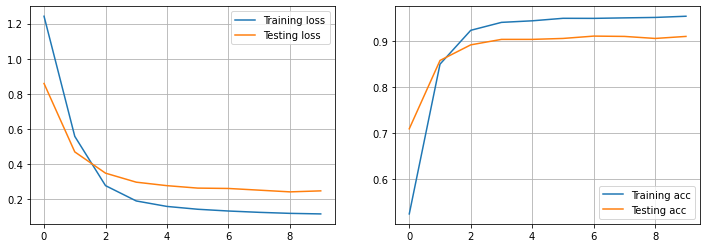

In [232]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_cnn = evaluate(cnn, batch_size, epochs)

In [237]:
### START YOUR CODE

cnn_big = Sequential()
cnn_big.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=(128, 9)))
cnn_big.add(MaxPooling1D(3))
cnn_big.add(Conv1D(32, 3, activation='relu', padding='same'))
cnn_big.add(MaxPooling1D(3))
cnn_big.add(Conv1D(16, 3, activation='relu', padding='same'))
cnn_big.add(MaxPooling1D(3))
cnn_big.add(Conv1D(8, 3, activation='relu', padding='same'))
cnn_big.add(MaxPooling1D(3))
cnn_big.add(Flatten())
cnn_big.add(Dense(120, activation='tanh'))
cnn_big.add(Dense(6, activation='softmax'))

cnn_big.summary()

### END YOUR CODE

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 128, 64)           1792      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 42, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 42, 32)            6176      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 14, 16)            1552      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 8)            

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 1s 184us/sample - loss: 1.3995 - accuracy: 0.4665 - val_loss: 0.9740 - val_accuracy: 0.6651
Epoch 2/10
7352/7352 [==============================] - 1s 126us/sample - loss: 0.6613 - accuracy: 0.8263 - val_loss: 0.4866 - val_accuracy: 0.8554
Epoch 3/10
7352/7352 [==============================] - 1s 127us/sample - loss: 0.2465 - accuracy: 0.9236 - val_loss: 0.3357 - val_accuracy: 0.8931
Epoch 4/10
7352/7352 [==============================] - 1s 126us/sample - loss: 0.1496 - accuracy: 0.9434 - val_loss: 0.3084 - val_accuracy: 0.8979
Epoch 5/10
7352/7352 [==============================] - 1s 126us/sample - loss: 0.1256 - accuracy: 0.9510 - val_loss: 0.3047 - val_accuracy: 0.8938
Epoch 6/10
7352/7352 [==============================] - 1s 126us/sample - loss: 0.1140 - accuracy: 0.9533 - val_loss: 0.3139 - val_accuracy: 0.8982
Epoch 7/10
7352/7352 [==============================] - 1s 127us

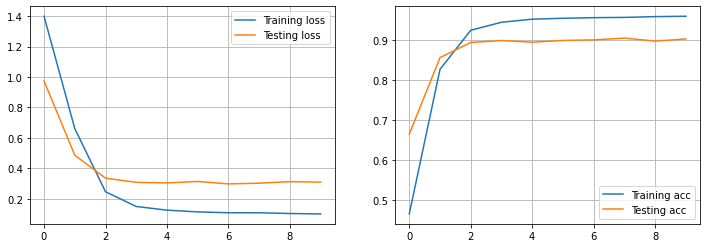

In [238]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_cnn_big = evaluate(cnn_big, batch_size, epochs)

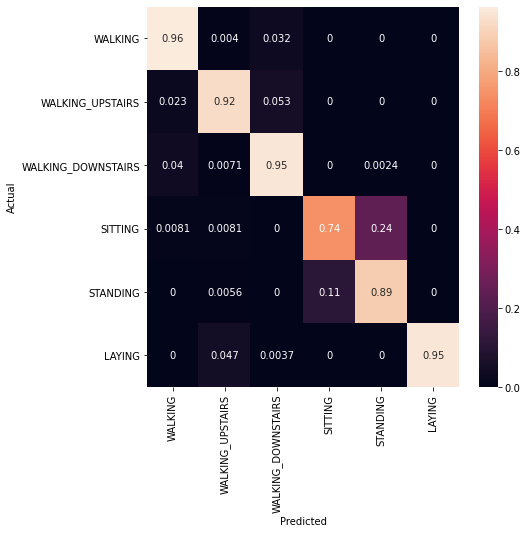

In [239]:
cm(cnn_big)

#### Findings

The number of convolution layers did not have a lot of influence on the test accuracy. However, the best results were made with the model with a layer less - bot buth have a test accuracy of around `0.9`. The more complex `CNN` model resulted in quite the same predictions as the stacked `LSTM` model - quite interesting. Here also, `STANDING` and `SITTING` get confused the most. But overall quite good results. 

### MLP

In [256]:
### START YOUR CODE

mlp = Sequential()
mlp.add(Flatten(input_shape=(128, 9)))
mlp.add(Dense(256, activation='sigmoid'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(6, activation='softmax'))

mlp.summary()

### END YOUR CODE

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_84 (Dense)             (None, 256)               295168    
_________________________________________________________________
dense_85 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_86 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_87 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_88 (Dense)             (None, 6)                 198       
Total params: 338,598
Trainable params: 338,598
Non-trainable params: 0
_______________________________________________

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 0s 56us/sample - loss: 1.0381 - accuracy: 0.6440 - val_loss: 0.7780 - val_accuracy: 0.7421
Epoch 2/10
7352/7352 [==============================] - 0s 29us/sample - loss: 0.3944 - accuracy: 0.8898 - val_loss: 0.4654 - val_accuracy: 0.8575
Epoch 3/10
7352/7352 [==============================] - 0s 29us/sample - loss: 0.1888 - accuracy: 0.9381 - val_loss: 0.3779 - val_accuracy: 0.8778
Epoch 4/10
7352/7352 [==============================] - 0s 27us/sample - loss: 0.1371 - accuracy: 0.9476 - val_loss: 0.3782 - val_accuracy: 0.8996
Epoch 5/10
7352/7352 [==============================] - 0s 26us/sample - loss: 0.1250 - accuracy: 0.9512 - val_loss: 0.3331 - val_accuracy: 0.9104
Epoch 6/10
7352/7352 [==============================] - 0s 26us/sample - loss: 0.1090 - accuracy: 0.9539 - val_loss: 0.3417 - val_accuracy: 0.9046
Epoch 7/10
7352/7352 [==============================] - 0s 26us/sample

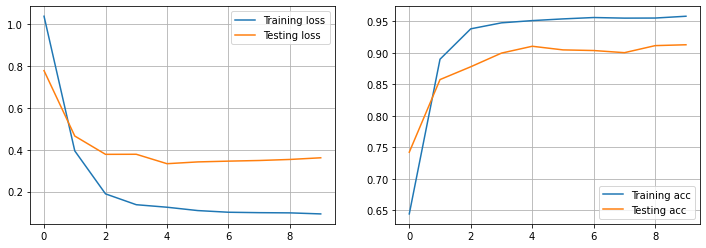

In [257]:
### START YOUR CODE
batch_size = 256
epochs = 10

log_mlp = evaluate(mlp, batch_size, epochs)

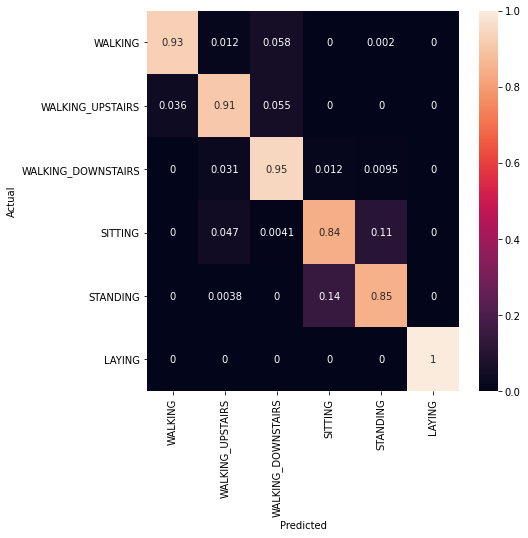

In [258]:
cm(mlp)

#### Findings

The `MLP` model also achieves an accuracy over `0.9` - `0.91` to be precise. Interestingly `STANDING` and `SITTING` get confused the most. We can also notice more issues with the differention of `WALKING` and `WALKING_UPSTAIRS`. But overall good results as well.